In this notebook I look at SHAP values in the context of simple linear models and index models to make its behaviour transparent in environments that econometricians are familiar with. I will consider 
1. Linear model with independent covariates
2. Linear model with dependent covariates
3. Index model (logit) with independent covariates
4. Index model (logit) with dependent covariates

### Linear model

see goodnotes.

### Logit

With the logit, there is no nice closed form solution for the conditional expected value of the prediction. Here, I will compute these integrals exactly using numerical integration through scipy. Alternatively, and probably much faster, would be to Monte-Carlo approximate those integrals.

In [1]:
import numpy as np
import scipy.integrate as integrate
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm

In [29]:
def get_sigma_decomposition(conditioning_indices, Sigma):
    """
    Decomposes the covariance matrix Sigma into three submatrices based on the conditioning indices.
    cf: https://stats.stackexchange.com/questions/30588/deriving-the-conditional-distributions-of-a-multivariate-normal-distribution

    Parameters:
    conditioning_indices (list): List of indices representing the conditioning variables.
    Sigma (numpy.ndarray): Covariance matrix.

    Returns:
    Sigma11 (numpy.ndarray): Submatrix of Sigma containing the non-conditioning variables.
    Sigma12 (numpy.ndarray): Submatrix of Sigma containing the cross-covariance between non-conditioning and conditioning variables.
    Sigma22 (numpy.ndarray): Submatrix of Sigma containing the conditioning variables.
    """
    non_conditioning_indices = [i for i in range(Sigma.shape[0]) if i not in conditioning_indices]
    Sigma11 = Sigma[np.ix_(non_conditioning_indices, non_conditioning_indices)]
    Sigma12 = Sigma[np.ix_(non_conditioning_indices, conditioning_indices)]
    Sigma22 = Sigma[np.ix_(conditioning_indices, conditioning_indices)]
    return Sigma11, Sigma12, Sigma22

# densities of conditional normal functions
def get_conditional_params(values, conditioning_var_inds=[1, 2], mus=np.array([0, 0, 0]), Sigma=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])):
    """
    Calculate the expected value and variance of a conditional normal distribution.

    Parameters:
    values (list): The observed values of the conditioning variables.
    conditioning_var_inds (list): The indices of the conditioning variables.
    mus (ndarray): The mean vector of the joint normal distribution.
    Sigma (ndarray): The covariance matrix of the joint normal distribution.

    Returns:
    tuple: A tuple containing the expected value and variance of the conditional normal distribution.
    """
    
    assert(len(values) == len(conditioning_var_inds))

    # generate list of variables by length of mus
    free_var_inds = [i for i in range(len(mus)) if i not in conditioning_var_inds]

    # get Sigma decomposition
    Sigma11, Sigma12, Sigma22 = get_sigma_decomposition(conditioning_var_inds, Sigma)
    # get expected value and variance of conditional normal distribution
    exp = mus[free_var_inds] + np.dot(Sigma12, np.dot(np.linalg.inv(Sigma22), (np.array(values) - mus[conditioning_var_inds])))
    sig = Sigma11 - np.dot(Sigma12, np.dot(np.linalg.inv(Sigma22), Sigma12.T))
    return exp, sig

def normal_conditional_density(x, conditioning_values, conditioning_indices, params={"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])}):
    """
    Calculates the conditional density of a multivariate normal distribution.

    Parameters:
    x (array-like): The value at which to evaluate the density.
    conditioning_values (array-like): The values of the conditioning variables.
    conditioning_indices (array-like): The indices of the conditioning variables.

    Returns:
    float: The value of the conditional density at x.
    """
    exp, sig = get_conditional_params(conditioning_values, conditioning_indices, mus=params["mus"], Sigma=params["Sigma"])
    assert(len(conditioning_values) == len(conditioning_indices))
    return mvn.pdf(x, mean=exp, cov=sig)


# logit
def f_logit(x, conditioning_values, conditioning_indices, weights = np.array([1, 1, 1])):
    # select weights using conditioning_indices and multiply with conditioning_values
    w = weights[conditioning_indices]
    summand = np.dot(w, conditioning_values)
    # get remaining weights
    if x is not None:
        w_remaining = weights[[i for i in range(len(weights)) if i not in conditioning_indices]]
        summand += np.dot(w_remaining, x)
    return np.sum(np.exp(summand)/(1 + np.exp(summand))) # sum to return scalar

In [62]:
# integrals for 3 variables
def E_f(values, conditioning_vars, params={"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "weights": np.array([1, 1, 1])}):
    assert(len(values) == len(conditioning_vars))
    normal_params = {"mus": params["mus"], "Sigma": params["Sigma"]}

    if len(conditioning_vars) == 3:
        result = f_logit(x = None, conditioning_values=values, conditioning_indices=conditioning_vars)
        error = None

    if len(conditioning_vars) == 2:
        result, error = integrate.quad(lambda x: normal_conditional_density(x, conditioning_values=values, conditioning_indices=conditioning_vars, params=normal_params) * f_logit(x, conditioning_values=values, conditioning_indices=conditioning_vars, weights=params["weights"]), -100, 100, epsabs=1.49e-04, epsrel=1.49e-04)
    
    if len(conditioning_vars) == 1:
        result, error = integrate.dblquad(lambda x,y: normal_conditional_density((x,y), conditioning_values=values, conditioning_indices=conditioning_vars, params=normal_params) * f_logit((x,y), conditioning_values=values, conditioning_indices=conditioning_vars, weights=params["weights"]), -100, 100, -100, 100, epsabs=1.49e-04, epsrel=1.49e-04)

    if len(conditioning_vars) == 0:
        result, error = integrate.tplquad(lambda x,y,z: mvn.pdf((x,y,z), mean=params["mus"], cov=params["Sigma"]) * f_logit((x,y,z), conditioning_values=values, conditioning_indices=conditioning_vars, weights=params["weights"]), -100, 100, -100, 100, -100, 100, epsabs=1.49e-04, epsrel=1.49e-04)

    return result, error


### checks and tests

In [35]:
weights = np.array([1, 1, 1])
weights[[1,2]]

array([1, 1])

In [36]:
f_logit(x = 2, conditioning_values = [0, 0], conditioning_indices = [1, 2], weights = np.array([1, 1, 1]))

0.8807970779778824

In [37]:
f_logit(x = (0,0), conditioning_values = [0], conditioning_indices = [1], weights = np.array([1, 1, 1]))

0.5

In [38]:
f_logit(x = (0,0,0), conditioning_values = [], conditioning_indices = [], weights = np.array([1, 1, 1]))

0.5

In [8]:
get_sigma_decomposition([1,2], Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]]))

(array([[1]]),
 array([[0, 0]]),
 array([[1, 0],
        [0, 1]]))

In [9]:
get_sigma_decomposition([2], Sigma = np.array([[1,0,0],[0,1,0],[0,0,1]]))

(array([[1, 0],
        [0, 1]]),
 array([[0],
        [0]]),
 array([[1]]))

In [10]:
get_conditional_params(values = [0], conditioning_var_inds = [2])

(array([0., 0.]),
 array([[1., 0.],
        [0., 1.]]))

In [11]:
normal_conditional_density(x = [0,0], conditioning_values=[0], conditioning_indices=[2])

0.15915494309189535

In [39]:
# check if the conditional densities are correct by integrating

integrate.dblquad(lambda x,y: normal_conditional_density((x,y), [0], [2]), -np.inf, np.inf, -np.inf, np.inf, epsabs=1.49e-04, epsrel=1.49e-04)

(1.0000000011805943, 0.0001413029331700994)

In [40]:
integrate.quad(lambda x: normal_conditional_density(x, [0,3], [1,2]), -np.inf, np.inf, epsabs=1.49e-04, epsrel=1.49e-04)

(0.9999999997941593, 9.361124086700034e-05)

In [41]:
integrate.quad(lambda x: f_logit(x, [0,0], [1,2]) * normal_conditional_density(x, [0,0], [1,2]), -100, 100)

(0.5000000000000001, 5.943013844712378e-13)

In [42]:
mvn.pdf((0,0,0), np.array([0,0,0]), np.array([[1,0,0],[0,1,0],[0,0,1]]))

0.06349363593424098

For some reason this only works if I throw in bounds of 100, for larger (e.g. np.inf) it doesnt compute the integral, I guess it has trouble with large values of the logic and small tail probability masses.

In [16]:
E_f(values = [1,2], conditioning_vars = [1,2])

(0.9306761419957146, 7.25675477206413e-13)

In [17]:
E_f(values = [1], conditioning_vars = [2])

(0.6750567023488913, 1.4870789199628173e-08)

### SHAP value computation via Kernel representation

In [21]:
M = 3
Z = np.ones((2**M, M+1))
Z[:, 1:] = np.unpackbits(np.arange(2**M, dtype=np.uint8)[:, np.newaxis], axis=1)[:, -M:]
print("Z built.")
Z

Z built.


array([[1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [88]:
M = 3

# define 2^M x (M+1) binary matrix representing all possible coalitions, first column being ones
Z = np.ones((2**M, M+1))
Z[:, 1:] = np.unpackbits(np.arange(2**M, dtype=np.uint8)[:, np.newaxis], axis=1)[:, -M:]

# define the 2^M x 2^M diagonal weight matrix, where each diagonal element is k(M,|S|), where S is resembles the binary representation of the coalition of the corresponding row in Z
# k(M,|S|) = (M-1)/((M choose |S|) * (M-|S|) * |S|)
W = np.zeros((2**M, 2**M))
for i in range(2**M):
    sum_Z = int(np.sum(Z[i, 1:]))
    if sum_Z == 0 or sum_Z == M:
        W[i, i] = 10e6 # should be infinity, in practice set to large constant
    else:
        W[i, i] = (M-1)/(math.comb(M, sum_Z) * (M-sum_Z) * sum_Z)


In [89]:
Z

array([[1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [90]:
W

array([[1.00000000e+07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.33333333e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.33333333e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.33333333e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 3.33333333e-01, 0.

In [91]:
import tqdm
import math

def Shapley_WLS(SHAP_value_function, data_instance, value_function_params):
    """Compute exact Shapley values as the optimal solution of a weighted least squares problem.

    Args:
        coalition_value_function (function): returns the value of the game for a given coalition.
        dataset (numpy.ndarray): The dataset for which to compute the Shapley values. (Implicitely assumed to have been generated under the same population distribution as the value function parameters)
    """
    # get nr of features
    M = len(data_instance)

    # define 2^M x (M+1) binary matrix representing all possible coalitions, first column being ones
    Z = np.ones((2**M, M+1))
    Z[:, 1:] = np.unpackbits(np.arange(2**M, dtype=np.uint8)[:, np.newaxis], axis=1)[:, -M:]
    print("Z built.")

    # define the 2^M x 2^M diagonal weight matrix, where  each element k(M,|S|), where S is resembles the binary representation of the coalition of the corresponding row in Z
    # k(M,|S|) = (M-1)/((M choose |S|) * (M-|S|) * |S|)
    W = np.zeros((2**M, 2**M))
    for i in range(2**M):
        sum_Z = int(np.sum(Z[i, 1:]))
        if sum_Z == 0 or sum_Z == M:
            W[i, i] = 10e6 # should be infinity, in practice set to large constant
        else:
            W[i, i] = (M-1)/(math.comb(M, sum_Z) * (M-sum_Z) * sum_Z)
    print(" W built.")
    
    # define the 2^M x 1 vector of the value of the game for each coalition
    print("Building v...")
    v = np.zeros((2**M, 1))
    for i in tqdm.tqdm(range(2**M)):
        conditioning_indices = np.where(Z[i, 1:] == 1)[0] # indices of "playing" features
        v[i] = SHAP_value_function(values = data_instance[conditioning_indices] , conditioning_vars = conditioning_indices, params = value_function_params)[0]
        print(f"v_{i}: {v[i]}")
    
    # compute solution: (Z'WZ)^-1Z'Wv
    shapley_values = np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(Z.T, W), Z)), Z.T), W), v)

    return shapley_values



Let's try if this works in the logit for a (0,0,0) instance: all instances are equal to their individual expectation, so the default shap value $\phi(\emptyset) = 0.5$ and the other are all zero...

In [92]:
SV = Shapley_WLS(SHAP_value_function = E_f, data_instance = np.array([0,0,0]), value_function_params = {"mus": np.array([0, 0, 0]), "Sigma": np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), "weights": np.array([1, 1, 1])})

Z built.
 W built.
Building v...


 12%|█▎        | 1/8 [01:54<13:21, 114.45s/it]

v_0: [0.50000741]


 25%|██▌       | 2/8 [01:57<04:53, 48.84s/it] 

v_1: [0.50000004]


 38%|███▊      | 3/8 [02:00<02:19, 27.86s/it]

v_2: [0.50000004]
v_3: [0.5]


100%|██████████| 8/8 [02:03<00:00, 15.42s/it]

v_4: [0.50000004]
v_5: [0.5]
v_6: [0.5]
v_7: [0.5]


These values are all right.

In [93]:
# print SV
SV

array([[ 5.00007409e-01],
       [-2.46896957e-06],
       [-2.47092606e-06],
       [-2.46960549e-06]])

Let's see the decomposition via a waterfall plot

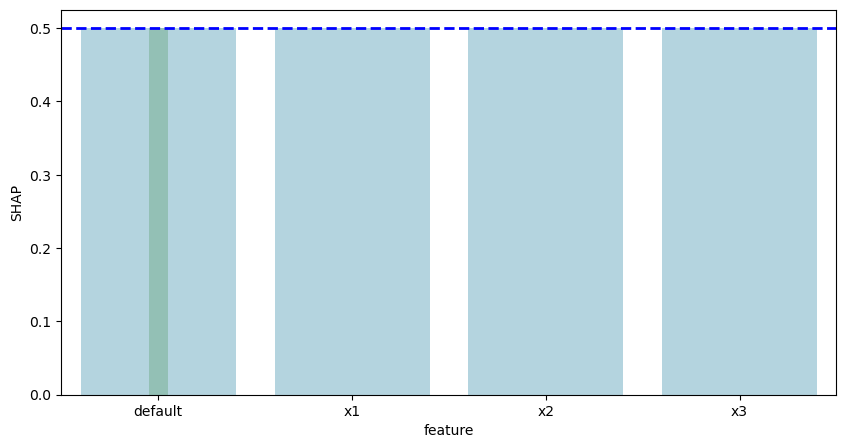

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# get model prediction for the instance
prediction = f_logit(x = np.array([0,0,0]), conditioning_values = [], conditioning_indices = [], weights = np.array([1, 1, 1]))
df = pd.DataFrame({"feature": ["default","x1", "x2", "x3"], "SHAP": SV.flatten(), "value": [0,1,2,3]})
df["cumulative_SHAP"] = df["SHAP"].cumsum()

# build waterfall plot
f = plt.figure(figsize=(10, 5))
sns.barplot(x="feature", y="cumulative_SHAP", data=df, color="lightblue")
sns.barplot(x="feature", y="SHAP", data=df, color="green", width=0.1, alpha = 0.2)
ax = plt.gca()
ax.axhline(prediction, color='blue', linewidth=2, linestyle='--')

plt.show()